# CSC3831 Final Assessment - Part I: Data Engineering



In [21]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Loading in the corrupted dataset to be used in analysis and imputation
houses_corrupted = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv', header=0)
# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


In [22]:
houses_corrupted.head()

median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   

   total_bedrooms  population  households  latitude  longitude  
0           129.0       322.0       126.0     37.88    -122.23  
1          1106.0      2401.0      1138.0     37.86    -122.22  
2           190.0         NaN       177.0     37.85    -122.24  
3           235.0         NaN       219.0     37.85    -122.25  
4           280.0       565.0       259.0     37.85    -122.25

In [23]:
houses_corrupted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


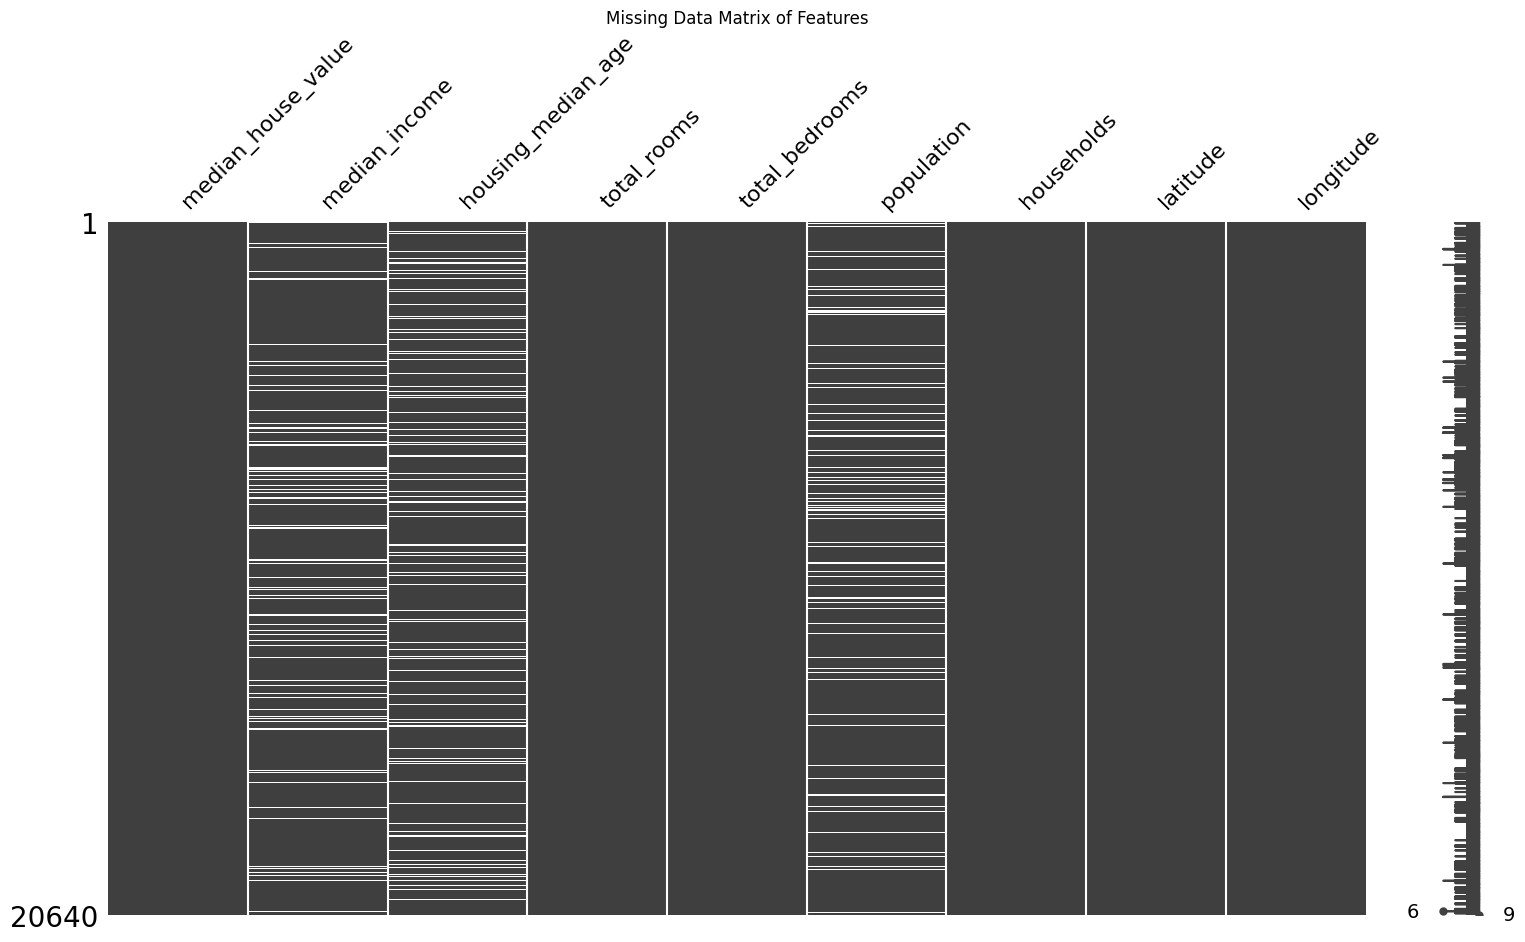

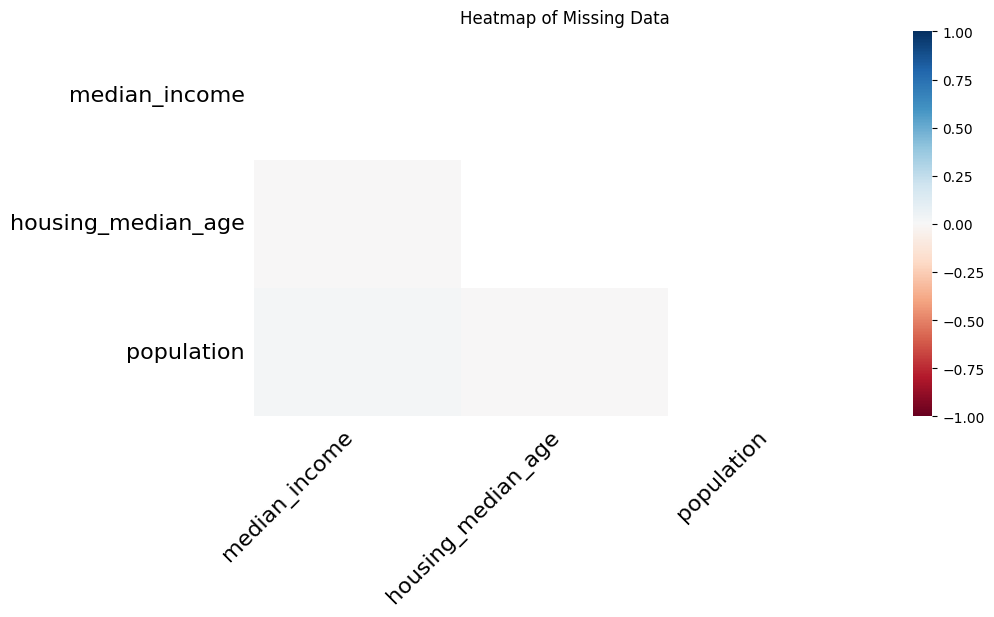

In [24]:
# Visualise missing data
msno.matrix(houses_corrupted, figsize=(18,9))
plt.title("Missing Data Matrix of Features")
plt.show()

# Heatmap to understand correlation in the missing data
msno.heatmap(houses_corrupted, figsize=(10,5))
plt.title("Heatmap of Missing Data")
plt.show()

The heatmap indicates the correlation (or lack thereof) between missing data in different features. The very light-colored cells indicate that there is little to no correlation between these features' appearance of missing values.

The missing data matrix provides an overview of the entire dataset, showing where missing values are located. White spaces denote missing data, and black bars show non-missing data.

There is missing data in the house_median_age, median_income, and population columns, which are distributed irregularly across the rows.

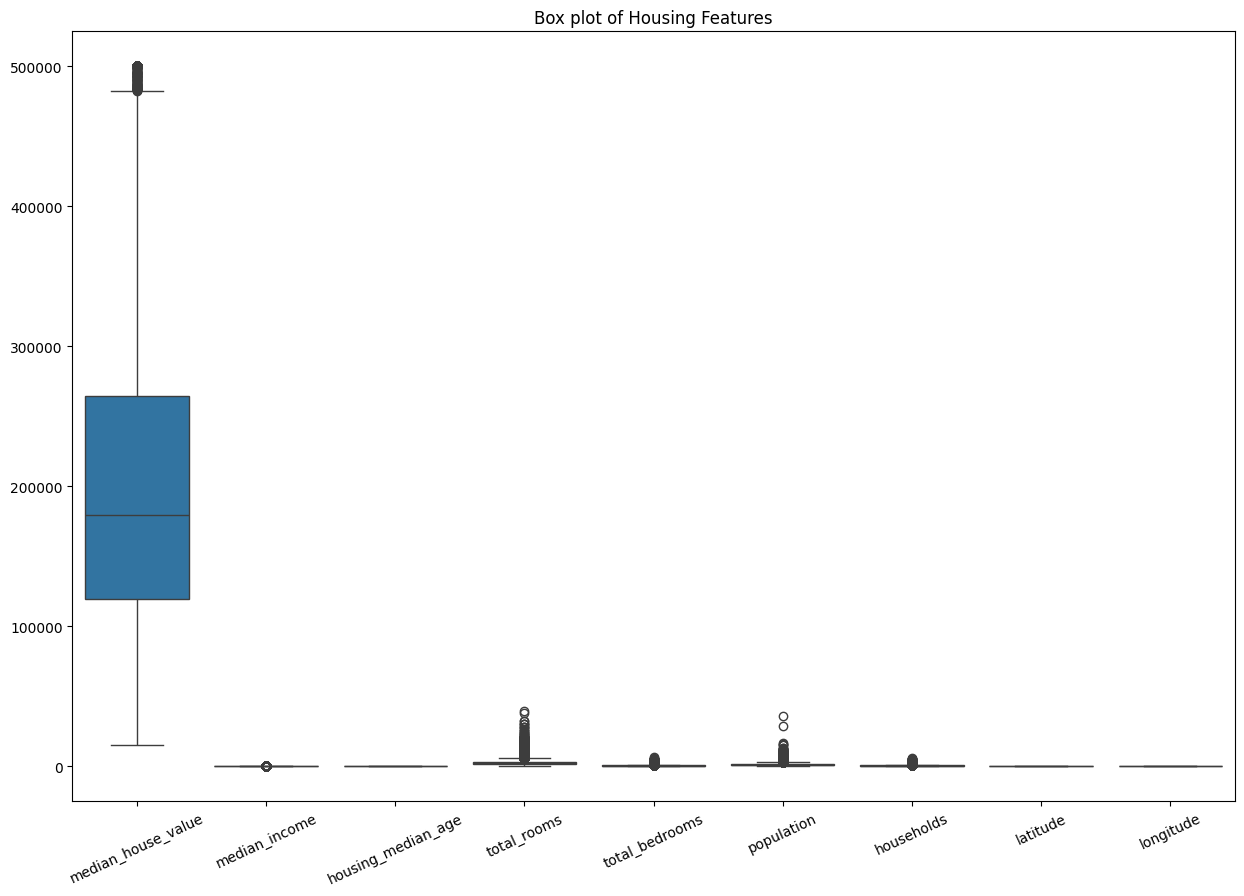

In [25]:
# Box plot representation for each feature
plt.figure(figsize=(15, 10))
sns.boxplot(data=houses_corrupted)
plt.xticks(rotation=25)
plt.title(f'Box plot of Housing Features')
plt.show()

This is a box plot for numerical columns to identify outliers.
Because of their wide range, features like median_house_value dominate the graph. The box plot appears compressed because the values for the other features are on a much smaller scale than median_house_value.

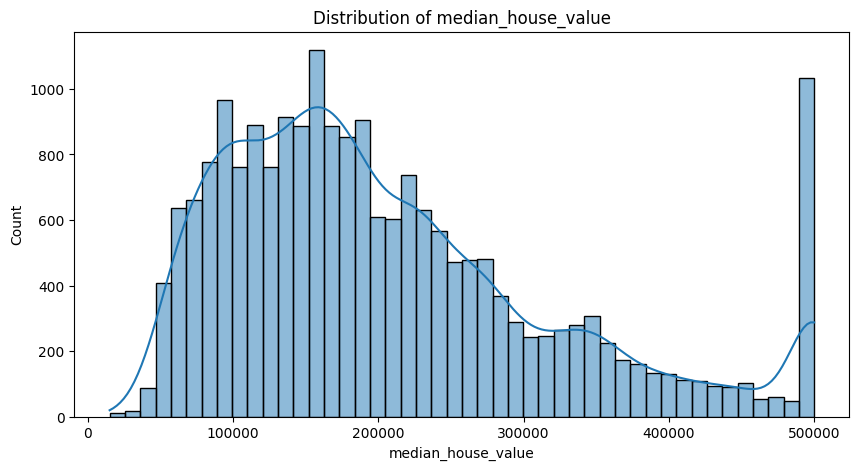

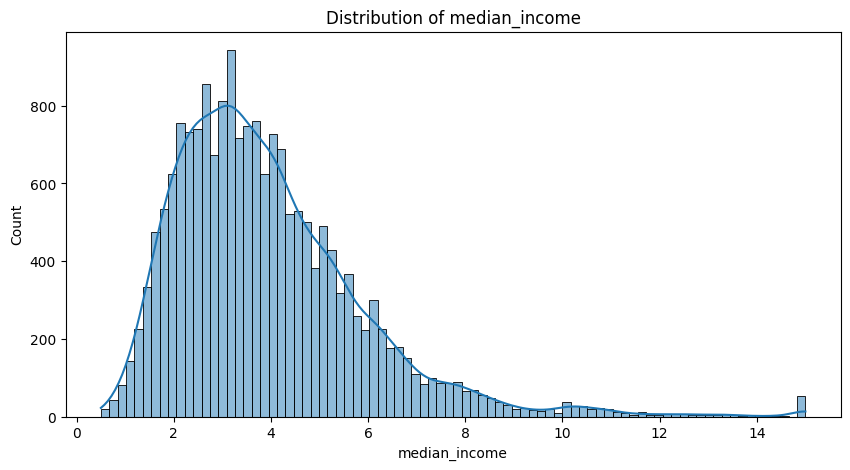

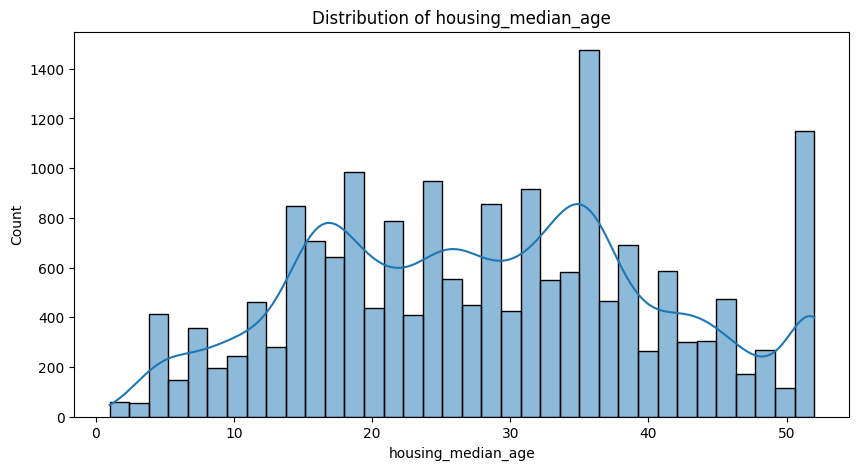

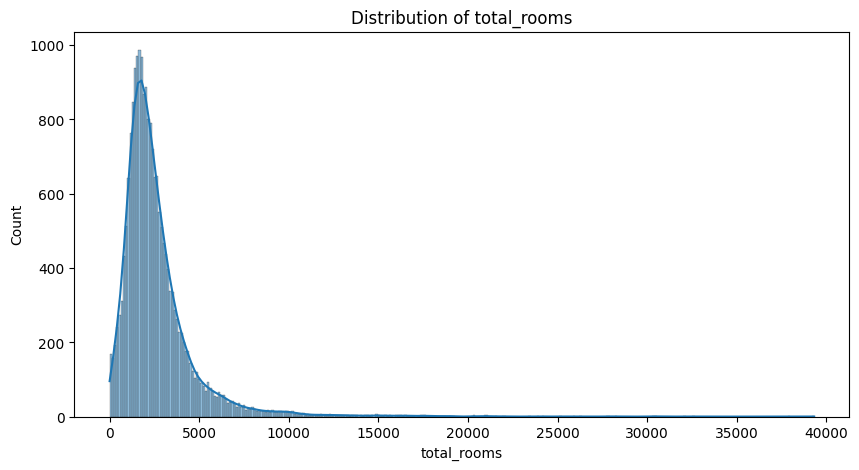

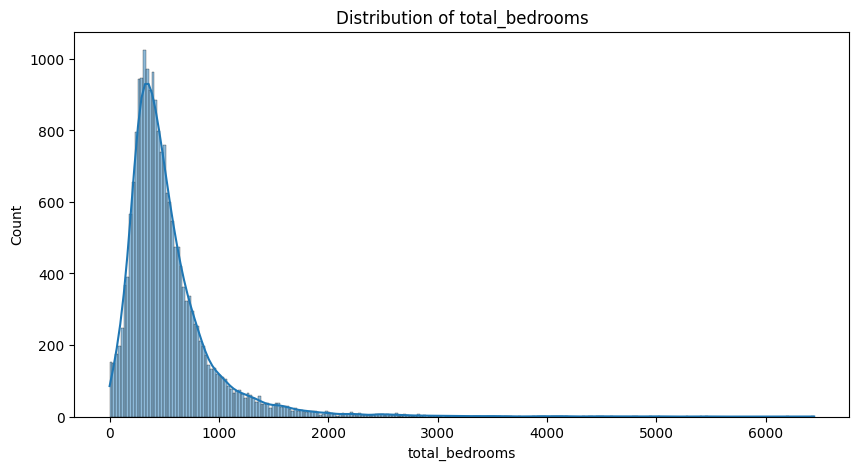

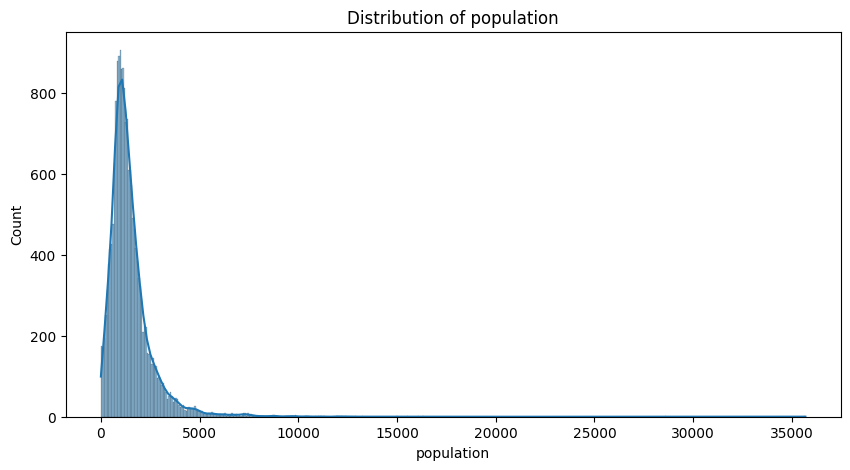

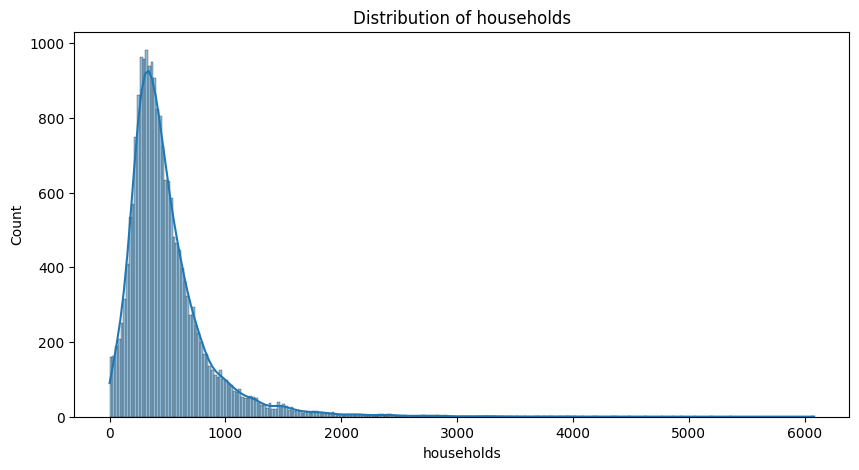

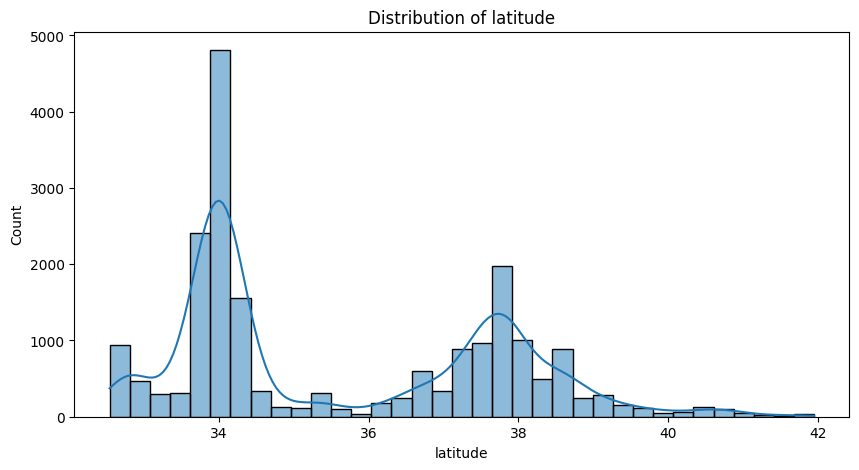

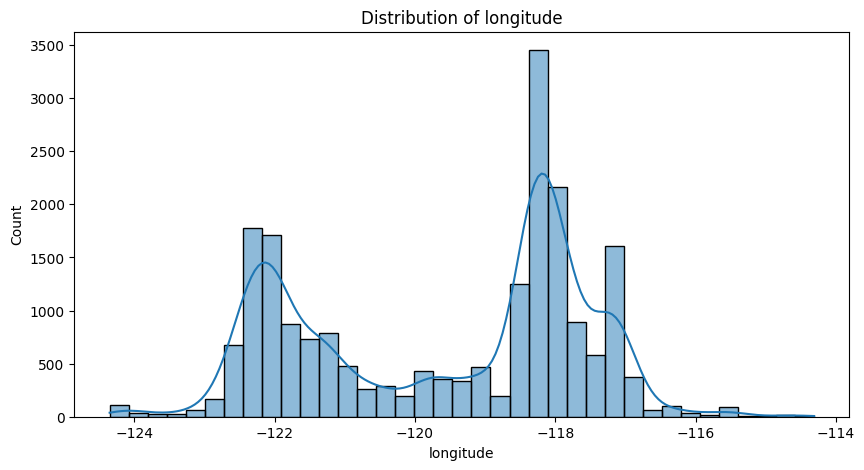

In [26]:
numeric_cols = houses_corrupted.select_dtypes(include=[np.number]).columns
# Histograms for numerical columns
for column in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(houses_corrupted[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()


These histograms shows the distribution of evry numerical feature and their skewness. The skew is further highlighted by the KDE (Kernel Density Estimate) curve that is overlaid and mirrors the histogram.

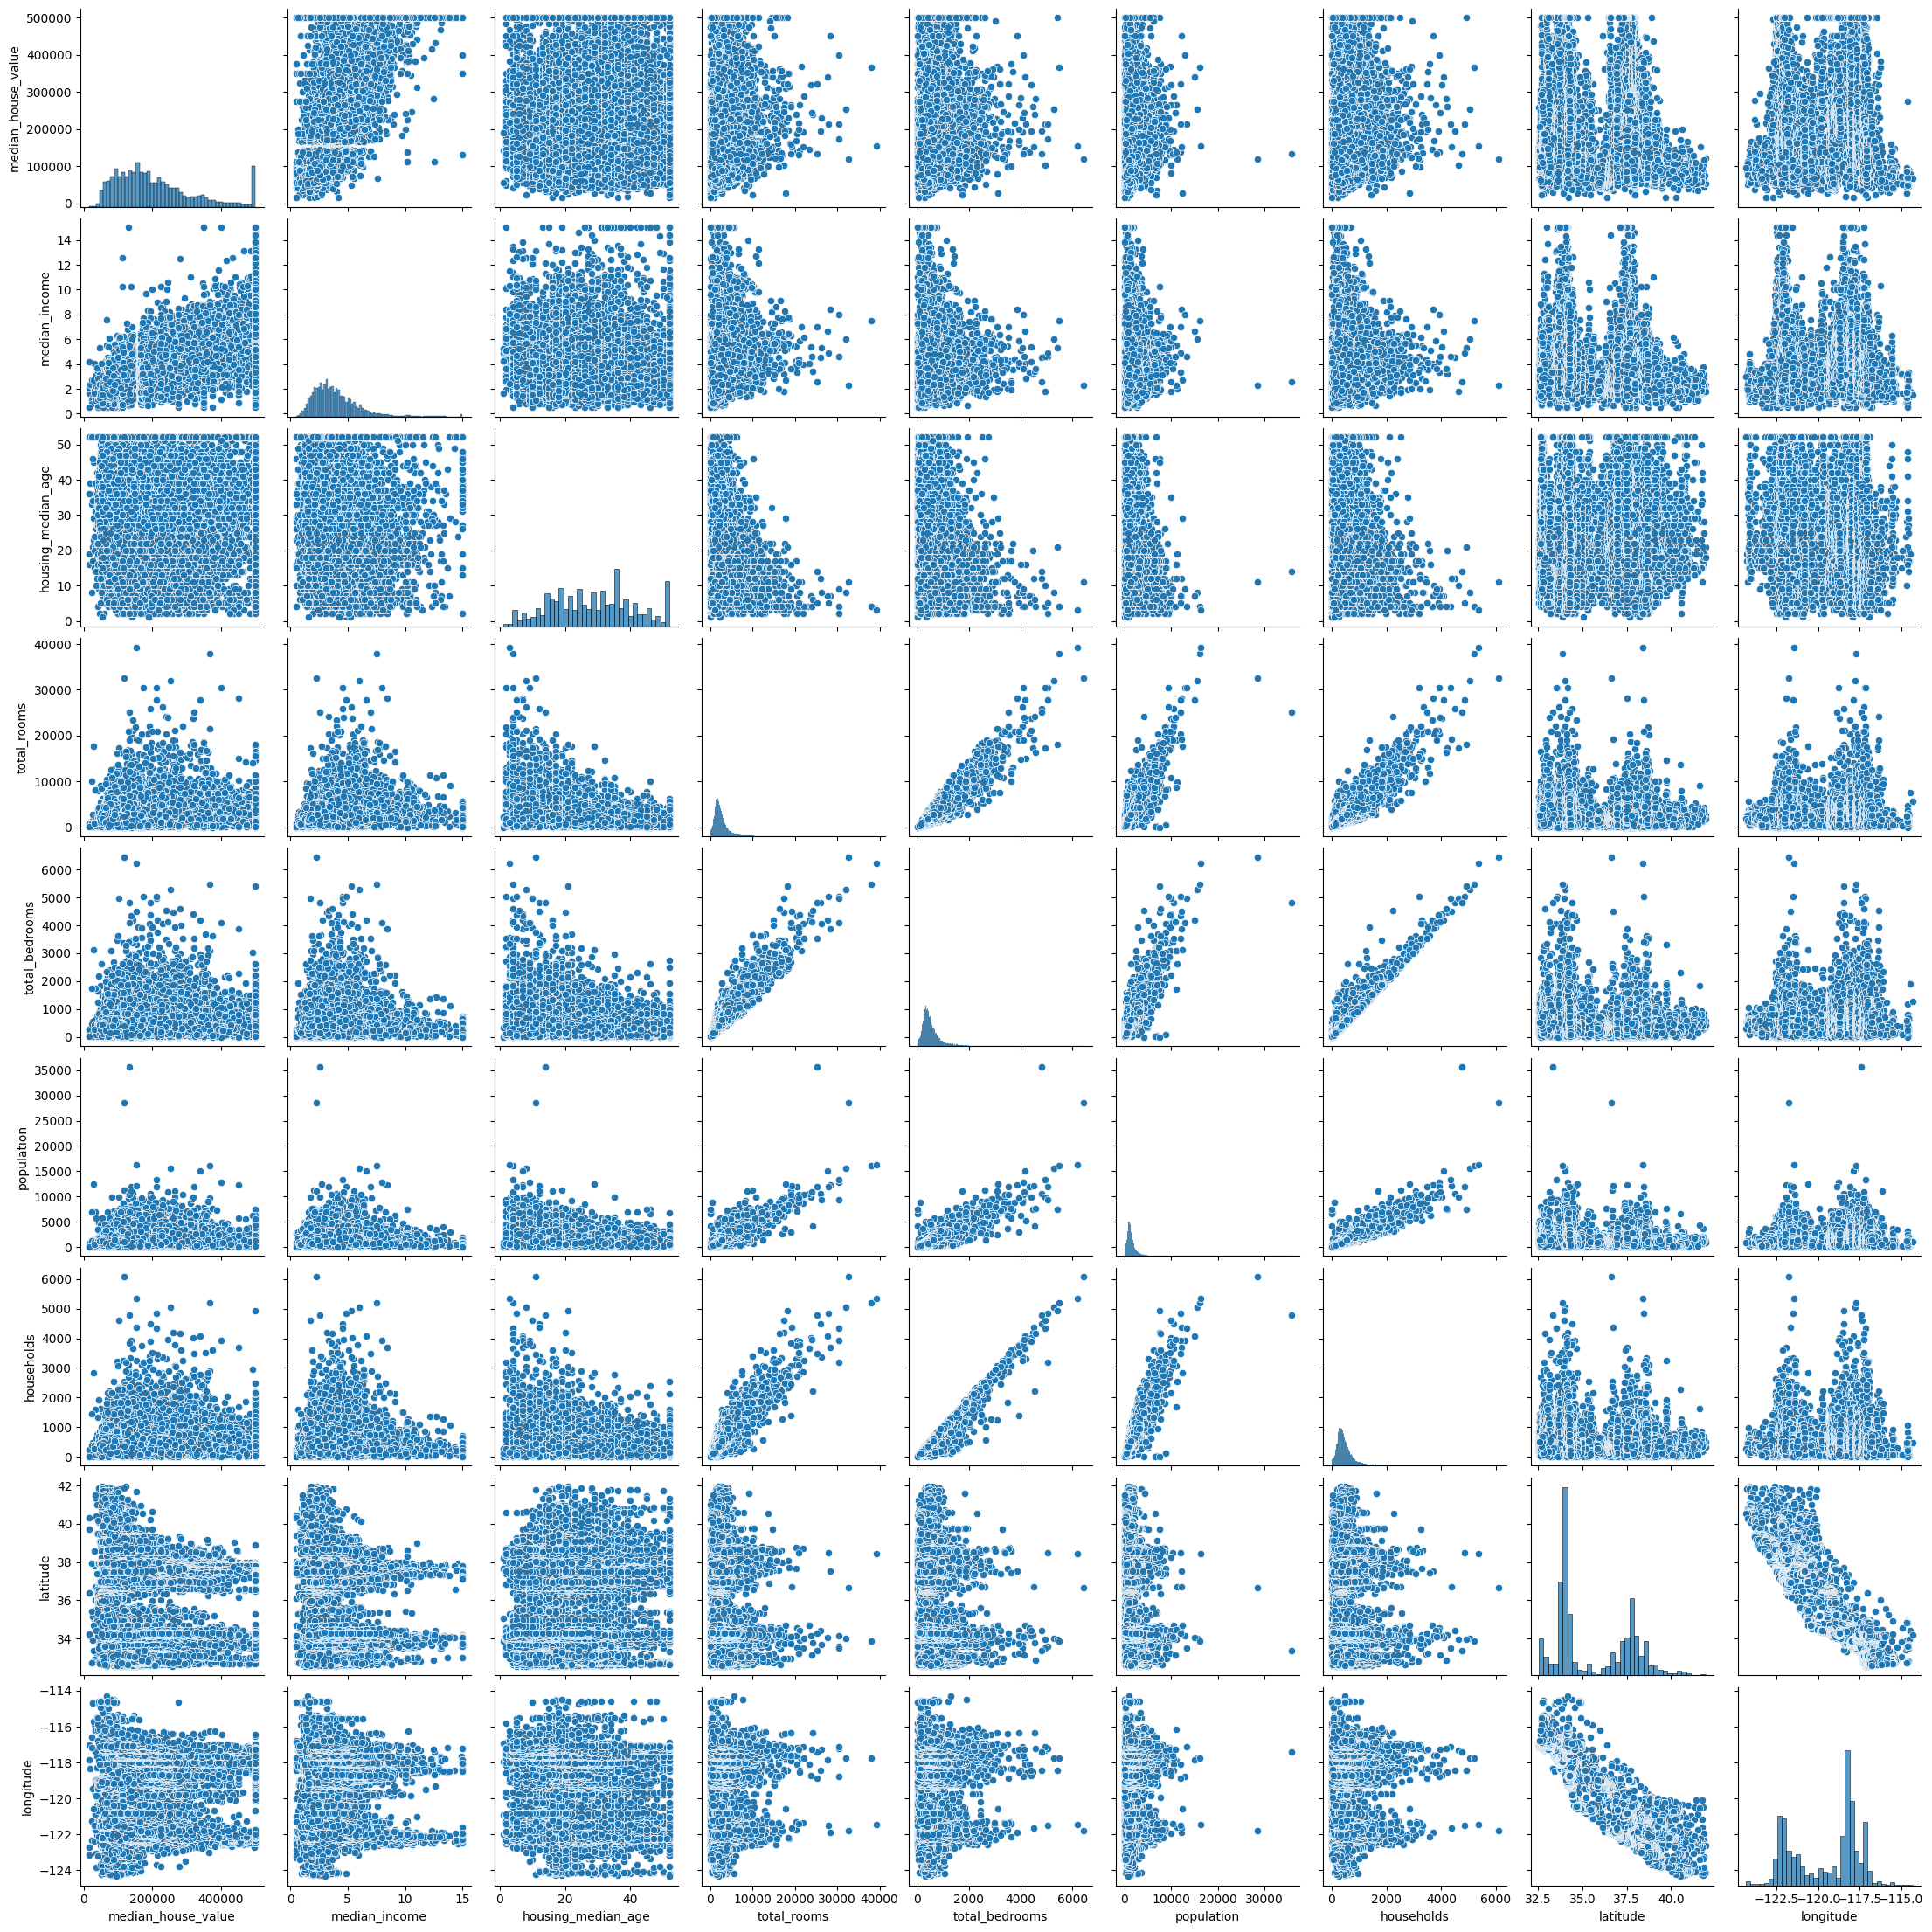

In [27]:
sns.pairplot(houses_corrupted)

The above representation is a pair plot, showing scatter plots for each pair of numerical features in the housing dataset along with histograms of individual features along the diagonal.

The scatter plots between total_rooms, total_bedrooms, population, and households show clear positive linear trends. These features are highly correlated, suggesting that they capture similar information about housing density or population.


In [28]:
houses_corrupted.describe()

median_house_value  median_income  housing_median_age   total_rooms  \
count        20640.000000   18576.000000        18576.000000  20640.000000   
mean        206855.816909       3.929958           28.324182   2635.763081   
std         115395.615874       1.964296           12.584914   2181.615252   
min          14999.000000       0.499900            1.000000      2.000000   
25%         119600.000000       2.560300           18.000000   1447.750000   
50%         179700.000000       3.572400           28.000000   2127.000000   
75%         264725.000000       4.870050           37.000000   3148.000000   
max         500001.000000      15.000100           52.000000  39320.000000   

       total_bedrooms    population    households      latitude     longitude  
count    20640.000000  18576.000000  20640.000000  20640.000000  20640.000000  
mean       537.898014   1488.069283    499.539680     35.631861   -119.569704  
std        421.247906   1170.585810    382.329753      2.135952      2.003532  
min          1.000000      3.000000      1.000000     32.540000   -124.350000  
25%        295.000000    839.000000    280.000000     33.930000   -121.800000  
50%        435.000000   1227.000000    409.000000     34.260000   -118.490000  
75%        647.000000   1803.000000    605.000000     37.710000   -118.010000  
max       6445.000000  35682.000000   6082.000000     41.950000   -114.310000

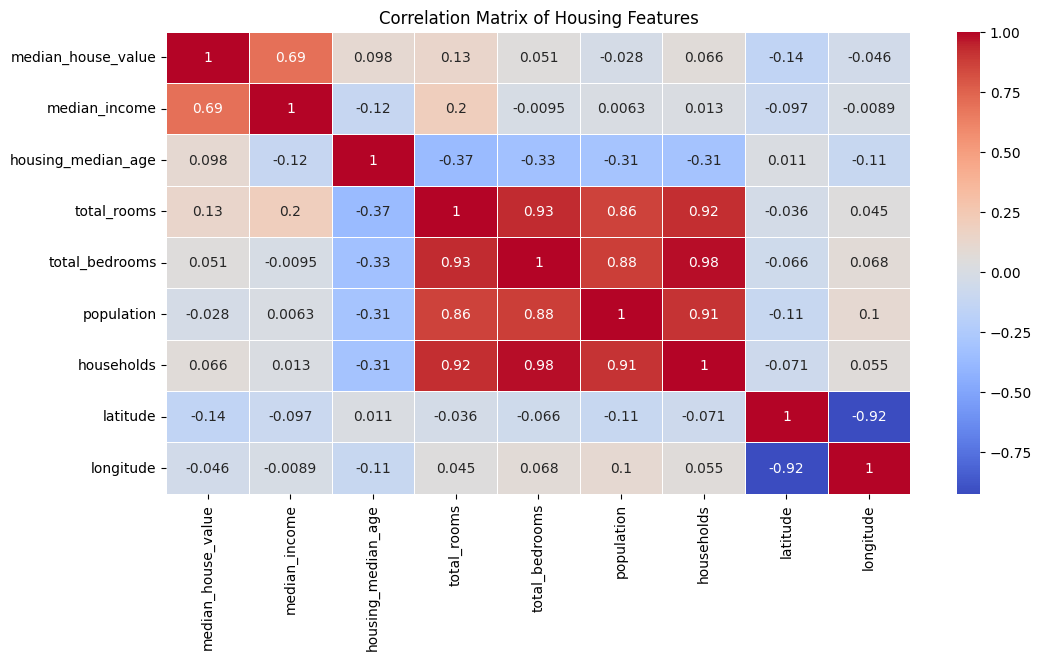

In [29]:
# Correlation matrix to understand relationships between numerical features
plt.figure(figsize=(12, 6))
corr_matrix = houses_corrupted.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.7)
plt.title('Correlation Matrix of Housing Features')
plt.show()

total_rooms, total_bedrooms, population, and households show strong positive correlations with each other. For example, total_rooms has a high correlation with total_bedrooms (0.93), population (0.86), and households (0.92).
This suggests that areas with more rooms tend to have more bedrooms, higher population and more households. These features may represent neighbourhood sizes or density of housing.

median_house_value has a moderate increase in correlation with median_income (0.69). This indicates that higher-income areas tend to have higher house values.

latitude and longitude have a strong negative correlation (-0.92) with each other. This likely reflects the geographic layout of the dataset area.

### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


## Statistical Outlier Detection Using IQR

The IQR approach uses the distribution of each feature to identify outliers. After determining a feature's 25th percentile (Q1) and 75th percentile (Q3), it determines the difference between the two. A value is considered an outlier if it is more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3.

median_house_value: 1071 outliers detected using IQR
median_income: 562 outliers detected using IQR
housing_median_age: 0 outliers detected using IQR
total_rooms: 1287 outliers detected using IQR
total_bedrooms: 1282 outliers detected using IQR
population: 1077 outliers detected using IQR
households: 1220 outliers detected using IQR
latitude: 0 outliers detected using IQR
longitude: 0 outliers detected using IQR


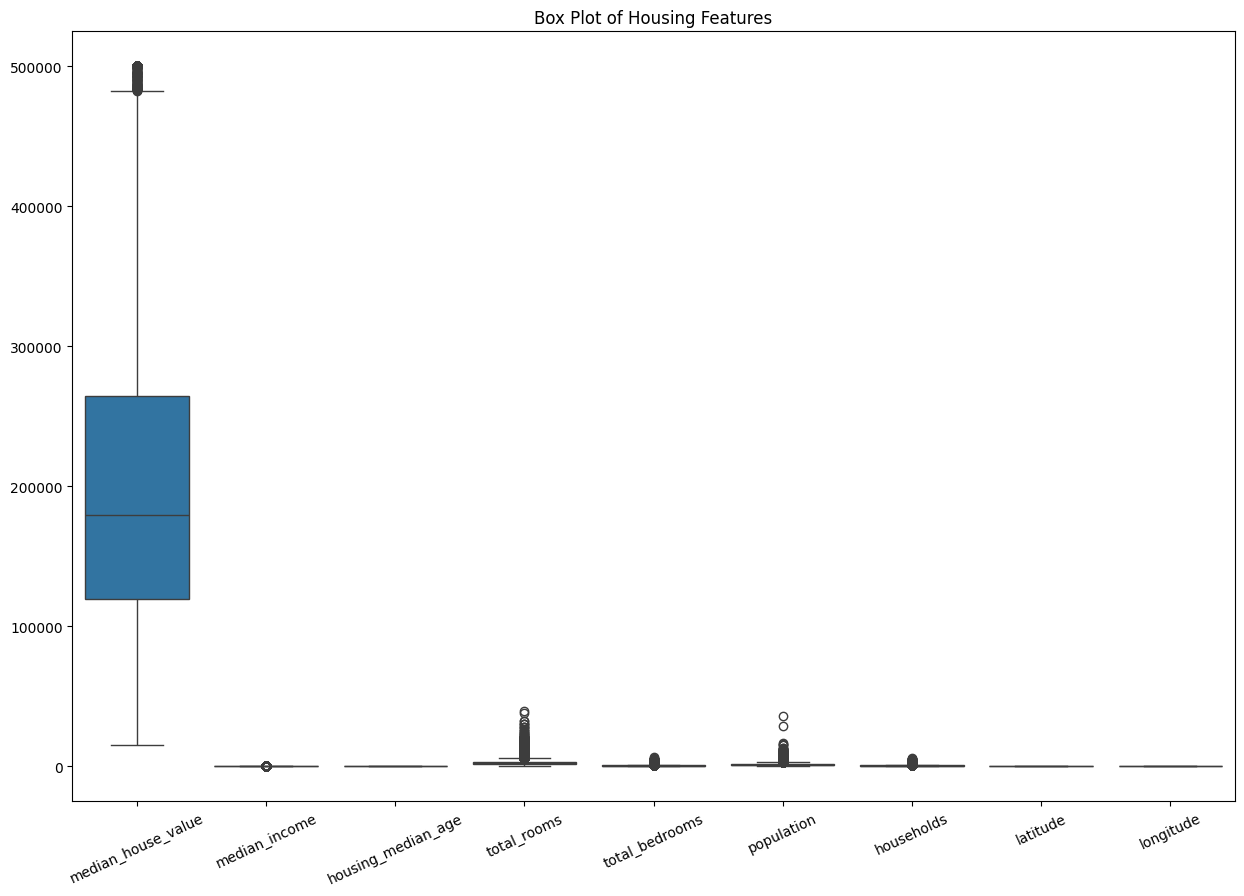

In [30]:
def detect_outliers(df, feature, threshold=1.5):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - threshold * IQR
    upper = Q3 + threshold * IQR
    return df[(df[feature] < lower) | (df[feature] > upper)]

iqr_outliers = {}
for column in houses_corrupted.select_dtypes(include=[np.number]).columns:
    outliers = detect_outliers(houses_corrupted, column)
    iqr_outliers[column] = len(outliers)
    print(f"{column}: {len(outliers)} outliers detected using IQR")

# Visualise using box plot for features with outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=houses_corrupted.select_dtypes(include=[np.number]))
plt.xticks(rotation=25)
plt.title("Box Plot of Housing Features")
plt.show()

### Why is this analysis appropriate?

IQR is a simple and robust way of finding outliers based on the spread of each feature individually. It does not assume a specific data shape, which makes it suitable for a variety of data distributions.

### Benefits

*   Easy to understand.
*   Makes zero assumptions about data distribution.
*   Good for univariate outliers (individual features).

### Drawbacks

*   It is unable to identify outliers based on relationships between features. It only applies to certain features.
*   It is unaffected by the shape of the data. If there is significant skewness in the data, it might overlook outliers.



## Detecting Outliers with Algorithmic Detection

The Isolation Forest algorithm finds outliers by randomly splitting data on different features. Points that are quickly separated in these splits are marked as outliers. When dealing with multivariate data, where correlations between multiple features may highlight particular data points, this approach works well.

1032 outliers detected using Isolation Forest


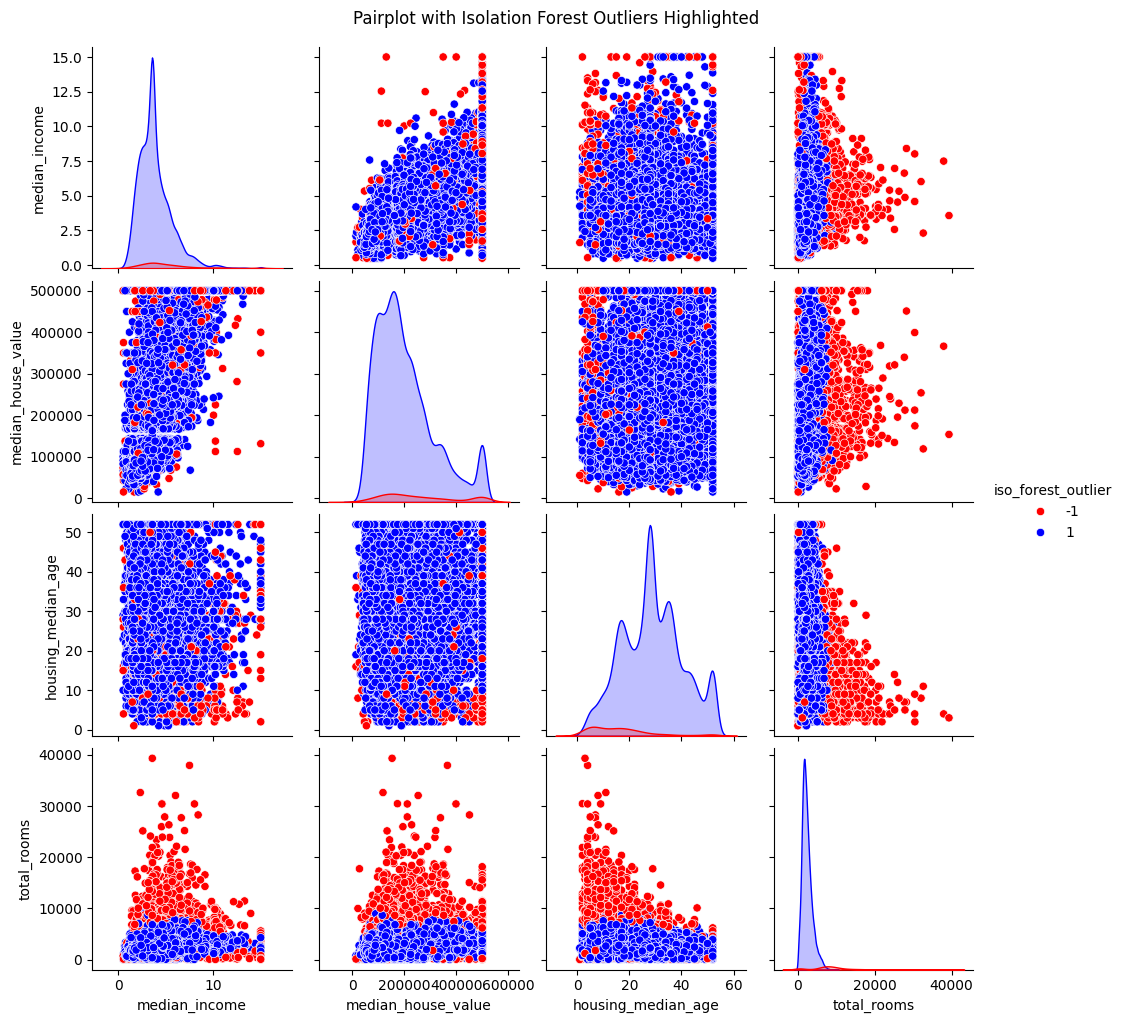

In [31]:
# Handle missing values by Imputation (to avoid getting an error about missing values in the dataset)
imputer = SimpleImputer(strategy="median")
houses_imputed = pd.DataFrame(imputer.fit_transform(houses_corrupted), columns=houses_corrupted.columns)

isolation_forest = IsolationForest(contamination=0.05, random_state=0)
houses_imputed['iso_forest_outlier'] = isolation_forest.fit_predict(houses_imputed.select_dtypes(include=[np.number]))

iso_forest_outliers = houses_imputed[houses_imputed['iso_forest_outlier'] == -1]
print(f"{len(iso_forest_outliers)} outliers detected using Isolation Forest")

# visualise outliers using pairplot for selected features
selected_features = ['median_income', 'median_house_value', 'housing_median_age', 'total_rooms']
sns.pairplot(houses_imputed[selected_features].join(houses_imputed['iso_forest_outlier']),
             hue='iso_forest_outlier', palette={1: 'blue', -1: 'red'})
plt.suptitle("Pairplot with Isolation Forest Outliers Highlighted", y=1.02)
plt.show()


The points of the scatter plot in red are outliers (identified by Isolation Forest) and the points in blue are inliers.
### Why is this analysis appropriate?

Isolation Forest uses the relationship between points across every feature to identify outliers. This makes it more effective at identifying outliers that only show up when we look at the data as a whole.

### Benefits

*   Considers all features together (multivariate).
*   Works well for large datasets.

### Drawbacks

*   Not perfect for subtle outliers: Might miss outliers in heavily skewed data.
*   Requires setting the contamination parameter (percentage of expected outliers).
*   Less interpretable at the individual feature level, as it only provides an overall set of outliers without detailing specific features involved.



## Comparing Results

We compare outliers detected by IQR and by Isolation Forest. This helps to see if there is any agreement between the methods.
We can find frequently marked outliers by comparing the different approaches. Most likely, these outliers are real anomalies.


In [32]:
iqr_outlier_summary = pd.DataFrame.from_dict(iqr_outliers, orient='index', columns=['IQR Outliers'])
alg_outlier_summary = pd.DataFrame({
    'Isolation Forest': [len(iso_forest_outliers)]}, index=['Outliers'])
compare_summary = pd.concat([iqr_outlier_summary, alg_outlier_summary.T], axis=1)
print("Outlier Summary Comparison:")
display(compare_summary)

Outlier Summary Comparison:


IQR Outliers  Outliers
median_house_value        1071.0       NaN
median_income              562.0       NaN
housing_median_age           0.0       NaN
total_rooms               1287.0       NaN
total_bedrooms            1282.0       NaN
population                1077.0       NaN
households                1220.0       NaN
latitude                     0.0       NaN
longitude                    0.0       NaN
Isolation Forest             NaN    1032.0

Based on the comparison and visualisation, we make a decision on which outliers to keep or remove. In this example, we remove all data points marked as outliers by at least one method.

In [33]:
# Collect number of rows of outliers detected by IQR
iqr_outlier_indices = pd.Index([])

for outliers in iqr_outliers.values():
    # Check if the outliers object has the 'index' attribute
    if isinstance(outliers, pd.Series) or isinstance(outliers, pd.DataFrame):
        iqr_outlier_indices = iqr_outlier_indices.union(outliers.index)

# Collect number of rows of outliers detected by Isolation Forest
iso_forest_outliers_indices = iso_forest_outliers.index

all_outlier_indices = iqr_outlier_indices.union(iso_forest_outliers_indices)
houses_cleaned = houses_corrupted.drop(all_outlier_indices)

print(f"Original dataset: {houses_corrupted.shape[0]} rows")
print(f"Cleaned dataset: {houses_cleaned.shape[0]} rows")

Original dataset: 20640 rows
Cleaned dataset: 19608 rows


Removing outliers can improve model performance by reducing noise, especially if the outliers are the result of data entry errors or are significantly different from the majority of the data.


### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


## Exploring Missing Data

In [34]:
# Use this dataset for comparison against the imputed datasets
houses = pd.read_csv('https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv', header=0)

print(houses_corrupted.info())

# Number of missing data
missing_values = houses_corrupted.isnull().sum()
print("\nMissing values per feature:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Missing values per feature:
 median_house_value       0
median_income         2064
housing_median_age    2064
total_rooms              0
total_bedrooms           0
population            2064
households               0
latitude                 0
longitude                0
dtype: int64


## Rationale to Choose Which Features to Impute or Remove

1. Features chosen for imputation:
    * median_income: This feature key factor in predicting house prices since income directly affects how much people can spend on housing.
    * population: Population gives us an idea of how crowded an area is, which affects housing demand.
    * housing_median_age: This shows how old houses in the area are, which plays a role in the value of the house.
  
2. Features to be removed: No features will be removed as they are essential for the housing market and there is no justification to remove any feature entirely.

## KNN Imputation


In [35]:
# Initialize and apply KNN Imputer
knn_imputer = KNNImputer(n_neighbors=3)
houses_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(houses_corrupted), columns=houses_corrupted.columns)
houses_knn_imputed.isnull().sum()

median_house_value    0
median_income         0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
latitude              0
longitude             0
dtype: int64

In [36]:
houses_knn_imputed.head()

median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   

   total_bedrooms   population  households  latitude  longitude  
0           129.0   322.000000       126.0     37.88    -122.23  
1          1106.0  2401.000000      1138.0     37.86    -122.22  
2           190.0   564.333333       177.0     37.85    -122.24  
3           235.0   594.000000       219.0     37.85    -122.25  
4           280.0   565.000000       259.0     37.85    -122.25

## MICE Imputation

In [37]:
# Initialize and apply MICE Imputer
mice_imputer = IterativeImputer()
houses_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(houses_corrupted), columns=houses_corrupted.columns)
houses_mice_imputed.isnull().sum()

median_house_value    0
median_income         0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
latitude              0
longitude             0
dtype: int64

In [38]:
houses_mice_imputed.head()

median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   

   total_bedrooms   population  households  latitude  longitude  
0           129.0   322.000000       126.0     37.88    -122.23  
1          1106.0  2401.000000      1138.0     37.86    -122.22  
2           190.0   405.994894       177.0     37.85    -122.24  
3           235.0   453.896591       219.0     37.85    -122.25  
4           280.0   565.000000       259.0     37.85    -122.25

## Comparing Imputed Data with Original Data

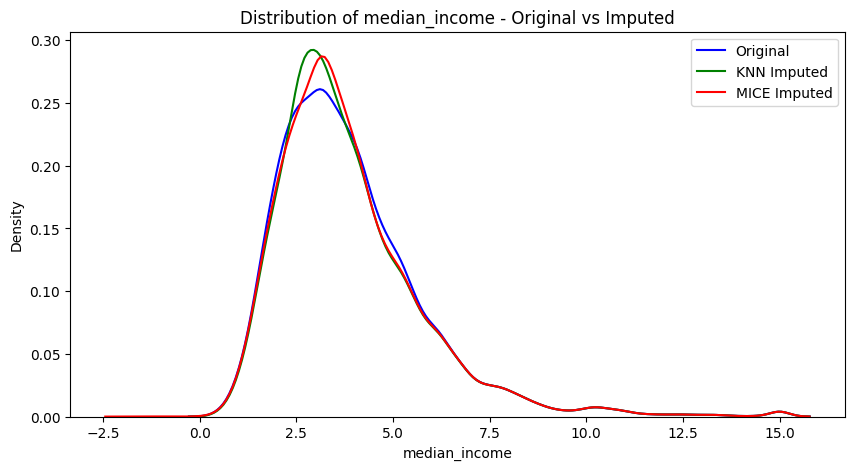

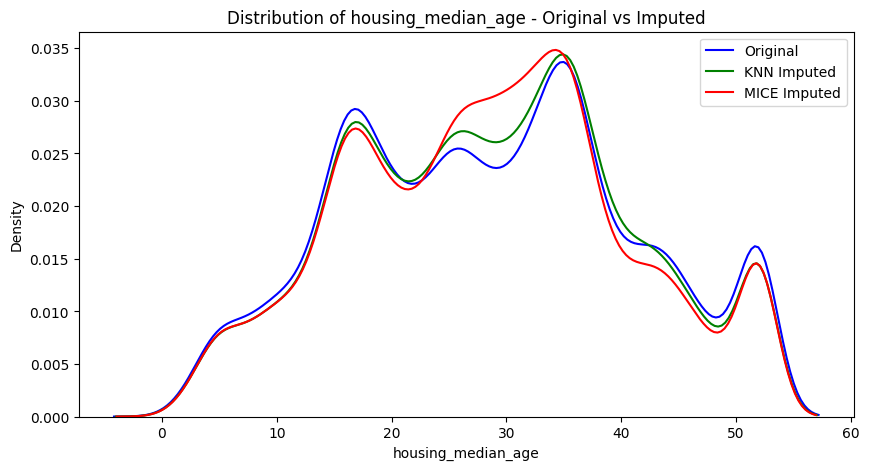

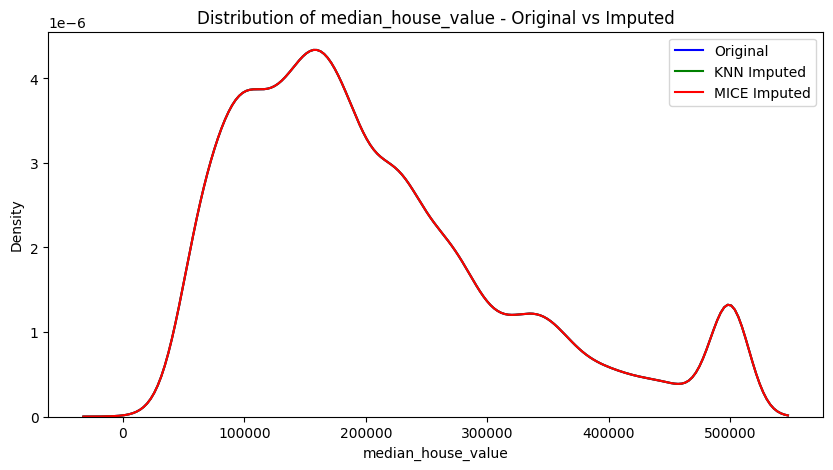

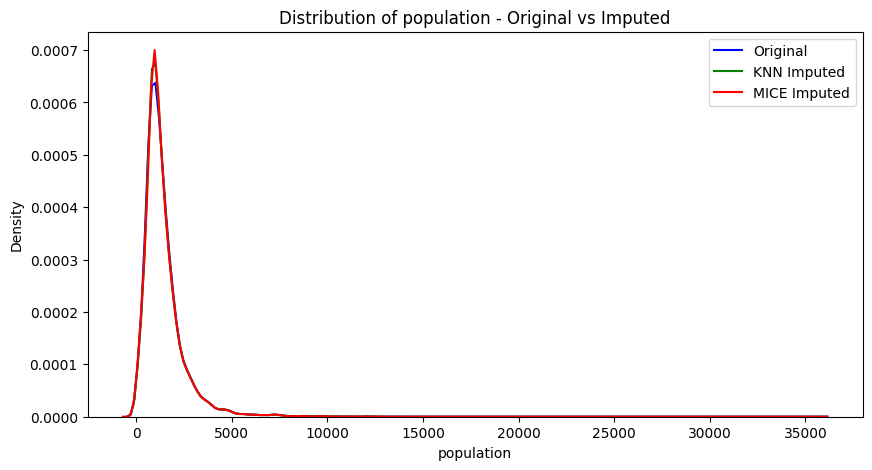

In [39]:
features_to_compare = ['median_income', 'housing_median_age', 'median_house_value', 'population']

for feature in features_to_compare:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(houses[feature].dropna(), label='Original', color='blue')
    sns.kdeplot(houses_knn_imputed[feature], label='KNN Imputed', color='green')
    sns.kdeplot(houses_mice_imputed[feature], label='MICE Imputed', color='red')
    plt.title(f'Distribution of {feature} - Original vs Imputed')
    plt.legend()
    plt.show()

## Regression Modeling

In [40]:
x = houses.drop('median_house_value', axis=1)
y = houses['median_house_value']

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(x, y, test_size=0.2, random_state=44)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(houses_knn_imputed.drop('median_house_value', axis=1), houses_knn_imputed['median_house_value'], test_size=0.2, random_state=44)
X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(houses_mice_imputed.drop('median_house_value', axis=1), houses_mice_imputed['median_house_value'], test_size=0.2, random_state=44)

model = LinearRegression()

# Original data
model.fit(X_train_orig, y_train_orig)
y_pred_orig = model.predict(X_test_orig)
mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
print(f'MSE on Original Data: {mse_orig}')

# KNN-imputed data
model.fit(X_train_knn, y_train_knn)
y_pred_knn = model.predict(X_test_knn)
mse_knn = mean_squared_error(y_test_knn, y_pred_knn)
print(f'MSE on KNN Imputed Data: {mse_knn}')

# MICE-imputed data
model.fit(X_train_mice, y_train_mice)
y_pred_mice = model.predict(X_test_mice)
mse_mice = mean_squared_error(y_test_mice, y_pred_mice)
print(f'MSE on MICE Imputed Data: {mse_mice}')


MSE on Original Data: 4729267517.926653
MSE on KNN Imputed Data: 4701480423.07897
MSE on MICE Imputed Data: 4552279973.120769


Based on the Mean Squared Error (MSE) values, the MICE Imputed Data provides the best performance as it results in the minimum MSE, which indicates that the regression model trained on the MICE imputed data makes the fewest errors.

KNN imputation appeared to have retained a significant amount of the original data's structure, as indicated by the slightly lower MSE of KNN compared to the original data.


### 4. Conclusions & Throughts [3]
- Disucss methods used for anomaly detection, pros/cons of each method
- Disucss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation

### 1. Methods Used for Anomaly Detection:
We used two approaches for anomaly detection: Interquartile Range (IQR) and Isolation Forest.
* Interquartile Range (IQR): The IQR method identifies outliers by calculating the range between the first (Q1) and third quartiles (Q3). Any data point outside 1.5 times the IQR (below Q1 or above Q3) is classified as an outlier.

  * Pros: Simple to understnad and implement. Works well with univariate data.
  * Cons: Limited to univariate outlier detection; does not consider relationships between features. It may overlook outliers if the data is skewed heavily.

* Isolation Forest: An algorithm that separates data points at random to isolate anomalies.

  * Pros: Handles multivariate outliers effectively. Works well for large datasets.
  * Cons: Requires hyperparameter tuning (contamination parameter)

### 2. Challenges and Difficulties in Anomaly Detection:
* Threshold Selection in IQR: Despite choosing the right threshold (such as 1.5 times the IQR) remained straightforward, there was a chance that normal data points would be mistakenly identified as outliers or that actual outliers would be missed, especially with skewed distributions.

* Contamination Parameter in Isolation Forest: Similar to the threshold selection in IQR, selecting the right contamination value was challenging as incorrect values could have lead to overestimating or underestimating anomalies.

* Due to its restriction to univariate analysis, the IQR approach is less useful for datasets with a large number of features. It would be inefficient and time-consuming to apply to multivariate datasets. For Isolation Forest, while efficient for large datasets, still requires significant computational resources to improve runtime.

### 3. Methods Used for Imputation:
For handling missing values, we used two imputation techniques: KNN and MICE.
* KNN: KNN fills in the missing values by imputing the missing value as the mean of the corresponding values of the k most comparable rows (neighbours) based on other features.

  * Pros: It is easy to implement and interpret.
  * Cons: Sensitive to k number of neighbors.

* MICE: MICE uses regression models to iteratively predict missing values based on other features, using known values as predictors.

  * Pros: Very accurate for datasets with complex structures.
  * Cons: It is computationaly rigourous, espcially for large datasets.

### 4. Challenges and Difficulties in Imputation:
*  There were minor differences in the imputed findings when missing values were imputed using both KNN and MICE. It was necessary to analyse and compare these results to decide which method was more suitable.
* KNN imputation's performance is dependent upon the value of n, or the number of neighbours.